In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_theme()
import math

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 20
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Helvetica"
n_colors = 10
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,0.8,n_colors)))

rng = np.random.default_rng(11)

In [2]:
# Monte Carlo Simulator for selling
def sim_MC(funct, # function that determines # of shares to trade at each time step
           pos_args = [],
           key_args = {},
           T = 100, # total trading period
           lamb = 0.01, 
           gamma = 0.01,
           sigma = 0.3, # asset volatility
           c = 1, # square root law
           tau = 10, # impact decay
           init_pos = 0, # initial position
           end_pos = 1000, # final position
           S0 = 10, # initial price of asset
           n_MC = 1000, # no. of MC simulations
           ):
    '''
    Runs Monte Carlo simulations for selling with price impact for a given trading strategy funct, then returns average of relevant quantities
    '''

    J = np.zeros((n_MC, T+1)) # EWMA of cumulative order flow
    I = np.zeros((n_MC, T+1)) # price impact
    Q = np.zeros((n_MC, T+1)) # position
    Y = np.zeros((n_MC, T+1)) # P&L
    alpha = np.zeros((n_MC, T+1)) # forecast
    S = np.zeros((n_MC, T+1)) # asset price w/o trading
    P = np.zeros((n_MC, T+1)) # price with impact
    x = np.zeros((n_MC, T)) # quantity to trade between t and t+1

    # Initialize starting values
    S[:,0] = S0
    P[:,0] = S0
    Q[:,0] = init_pos

    key_args['tot_q'] = end_pos - init_pos
    key_args['t_steps'] = T

    for i in range(T):
        if i == T-1: # if at the last time step, need to sell all shares
            x[:,i] = end_pos-Q[:,i]
        else:
            # determine x[i] given I[i], alpha[i], P[i], T-i, Q[i]
            # input function gives execution price as function of quantity,
            # need to know decay function, alpha, how long it decays
            key_args['rem_q'] = end_pos - Q[:,i]
            key_args['alpha'] = alpha[:,i]
            key_args['rem_t'] = T-i
            x[:,i] = funct(*pos_args, **key_args)
            # if i == 3:
            #     print(x[:5,i]) 

        # Update variables for next time step according to equations
        J[:,i+1] = np.exp(-1/tau) * J[:,i] + 0.5 * x[:,i] * (1 + np.exp(-1/(2*tau)))
        if c == 0.5:
            I[:,i+1] = lamb * np.sign(J[:,i+1]) * np.sqrt(abs(J[:,i+1]))
        else:
            I[:,i+1] = lamb * np.sign(J[:,i+1]) * abs(J[:,i+1]) ** c
        alpha[:,i+1] = np.exp(-1/tau) * alpha[:,i] + gamma * rng.standard_normal(size = n_MC)
        S[:,i+1] = S[:,i] + alpha[:,i+1] + sigma * rng.standard_normal(size = n_MC)
        P[:,i+1] = S[:,i+1] + I[:,i+1]
        Q[:,i+1] = Q[:,i] + x[:,i]
        Y[:,i+1] = Y[:,i] - x[:,i] * I[:,i+1] + Q[:,i] * (S[:,i+1]-S[:,i])


    # Take mean over all MC simulations
    avg_J = np.mean(J, axis = 0)
    # avg_I = np.mean(I, axis = 0)
    avg_I = lamb * np.sign(avg_J)* abs(avg_J)**c
    avg_Q = np.mean(Q, axis = 0)
    avg_Y = np.mean(Y, axis = 0)
    avg_alpha = np.mean(alpha, axis = 0)
    avg_S = np.mean(S, axis = 0)
    avg_P = np.mean(P, axis = 0)
    
    data = pd.DataFrame({
        'J': avg_J,
        'I': avg_I,
        'alpha': avg_alpha,
        'S': avg_S,
        'P': avg_P,
        'Q': avg_Q,
        'Y': avg_Y
        })

    return data



# Plotter
def plot_results(f_title, df, save_fig = False, fpath = ""):
    '''
    Plot averages of MC sim with option to save fig
    '''
    
    # Create a figure and axis
    N = 6                
    fig, axes = plt.subplots(ncols = 2, nrows = math.ceil(N/2), layout='constrained', figsize=(10 * 2, 6 * math.ceil(N/2)))

    # Columns to plot
    cols = ['Q', 'Y', 'J', 'I', 'alpha', 'S', 'P']
    ylabs = [r"\# of Shares", r"P\&L (\$)", r"Cum. Order Flow", r"Price Impact", r"Price Signal", r"Price (\$)"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Forecast ($\mathbf{\alpha_t}$)", r"Asset Price"]

    for i, c in enumerate(ylabs):
        if i < 5:
            axes[i//2, i%2].plot(df[cols[i]], ".-")
        else:
            axes[i//2, i%2].plot(df[cols[i]], ".-", label = r"$\mathbf{S_t}$")
            axes[i//2, i%2].plot(df[cols[i+1]], "v-", label = r"$\mathbf{P_t}$", c = 'blue')
            axes[i//2, i%2].legend()
            last_val = df[cols[i+1]].iloc[len(df)-1]
            axes[i // 2, i % 2].text(len(df)-1, last_val, f'{last_val:.3f}', va='bottom')

        # Annotate value at last time step
        last_val = df[cols[i]].iloc[len(df)-1]
        axes[i // 2, i % 2].text(len(df)-1, last_val, f'{last_val:.3f}', va='bottom')
        
        axes[i//2, i%2].set_xlabel("Time")
        axes[i//2, i%2].set_ylabel(c)
        axes[i//2, i%2].set_title(titles[i])

    fig.suptitle(f"{f_title}", fontsize=24, fontweight = "heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')
    return fig



def plot_multi_results(f_title, df, logsc = False, save_fig=False, fpath=""):
    '''
    Plot averages of multidimensional MC sim with option to save fig
    data is a dict
    '''

    # Create a figure and axis
    N = 6                
    fig, axes = plt.subplots(ncols = 2, nrows = math.ceil(N/2), layout='constrained', figsize=(10 * 2, 6 * math.ceil(N/2)))

    # Columns to plot
    cols = ['Q', 'Y', 'J', 'I', 'alpha', 'S', 'P']
    ylabs = [r"\# of Shares", r"P\&L (\$)", r"Cum. Order Flow", r"Price Impact", r"Price Signal", r"Price (\$)"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Forecast ($\mathbf{\alpha_t}$)", r"Asset Price"]

    # if want to plot only P and not S
    # for i, c in enumerate(ylabs):
    #     leg_labels = []
    #     for p in df.keys():
    #         axes[i//2, i%2].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

    #         # Calculate final value
    #         final_val = df[p][cols[i]].iloc[len(df[p])-1]
    #         leg_labels.append(rf"$p={p:.2f}$, {final_val:.2f}")

    for i, c in enumerate(ylabs):
        lines = []
        leg_labels = []
        for p in df.keys():
            if i < 5:
                l, = axes[i//2, i%2].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

                # Calculate final value
                final_val = df[p][cols[i]].iloc[len(df[p])-1]
            else:
                axes[i//2, i%2].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")
                l, = axes[i//2, i%2].plot(df[p][cols[i+1]], "v-", c = axes[i//2, i%2].lines[-1].get_c(), label = rf"$p={p:.2f}$")

                # Calculate final value of P
                final_val = df[p][cols[i + 1]].iloc[len(df[p])-1]

            lines.append(l)
            leg_labels.append(rf"$p={p:.2f}$, {final_val:.3f}")

        axes[i//2, i%2].set_xlabel("Time")
        axes[i//2, i%2].set_ylabel(c)
        axes[i//2, i%2].set_title(titles[i])
        if i < 4: axes[i//2, i%2].legend(lines, leg_labels, ncols = 2, prop = {'size': 12})
        elif i == 5:
            leg1 = axes[i//2, i%2].legend(lines, leg_labels, ncols = 2, prop = {'size': 12}, loc = 'lower left')
            axes[i//2, i%2].add_artist(leg1)
            handles = [Line2D([], [], marker=marker) for marker in ['.', 'v']]
            axes[i//2, i%2].legend(handles = handles, labels = [r'$S_t$', r'$P_t$'], prop = {'size': 15})
            
    # first create a dummy legend, so fig.tight_layout() makes enough space
    axes[0, 0].legend(handles=axes[0, 0].lines[:1], bbox_to_anchor=(0, 1.12), loc='lower left')
    fig.tight_layout(pad=3.0)

    # now create the real legend
    axes[0, 0].legend(handles=axes[0, 0].lines, ncols = len(df.keys()), bbox_to_anchor=(1.03, 1.12), loc='lower center', fontsize=18)

    fig.suptitle(f"{f_title}", fontsize=24, fontweight="heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')

    return fig

## Constant x {-}

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_973/1981267874.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


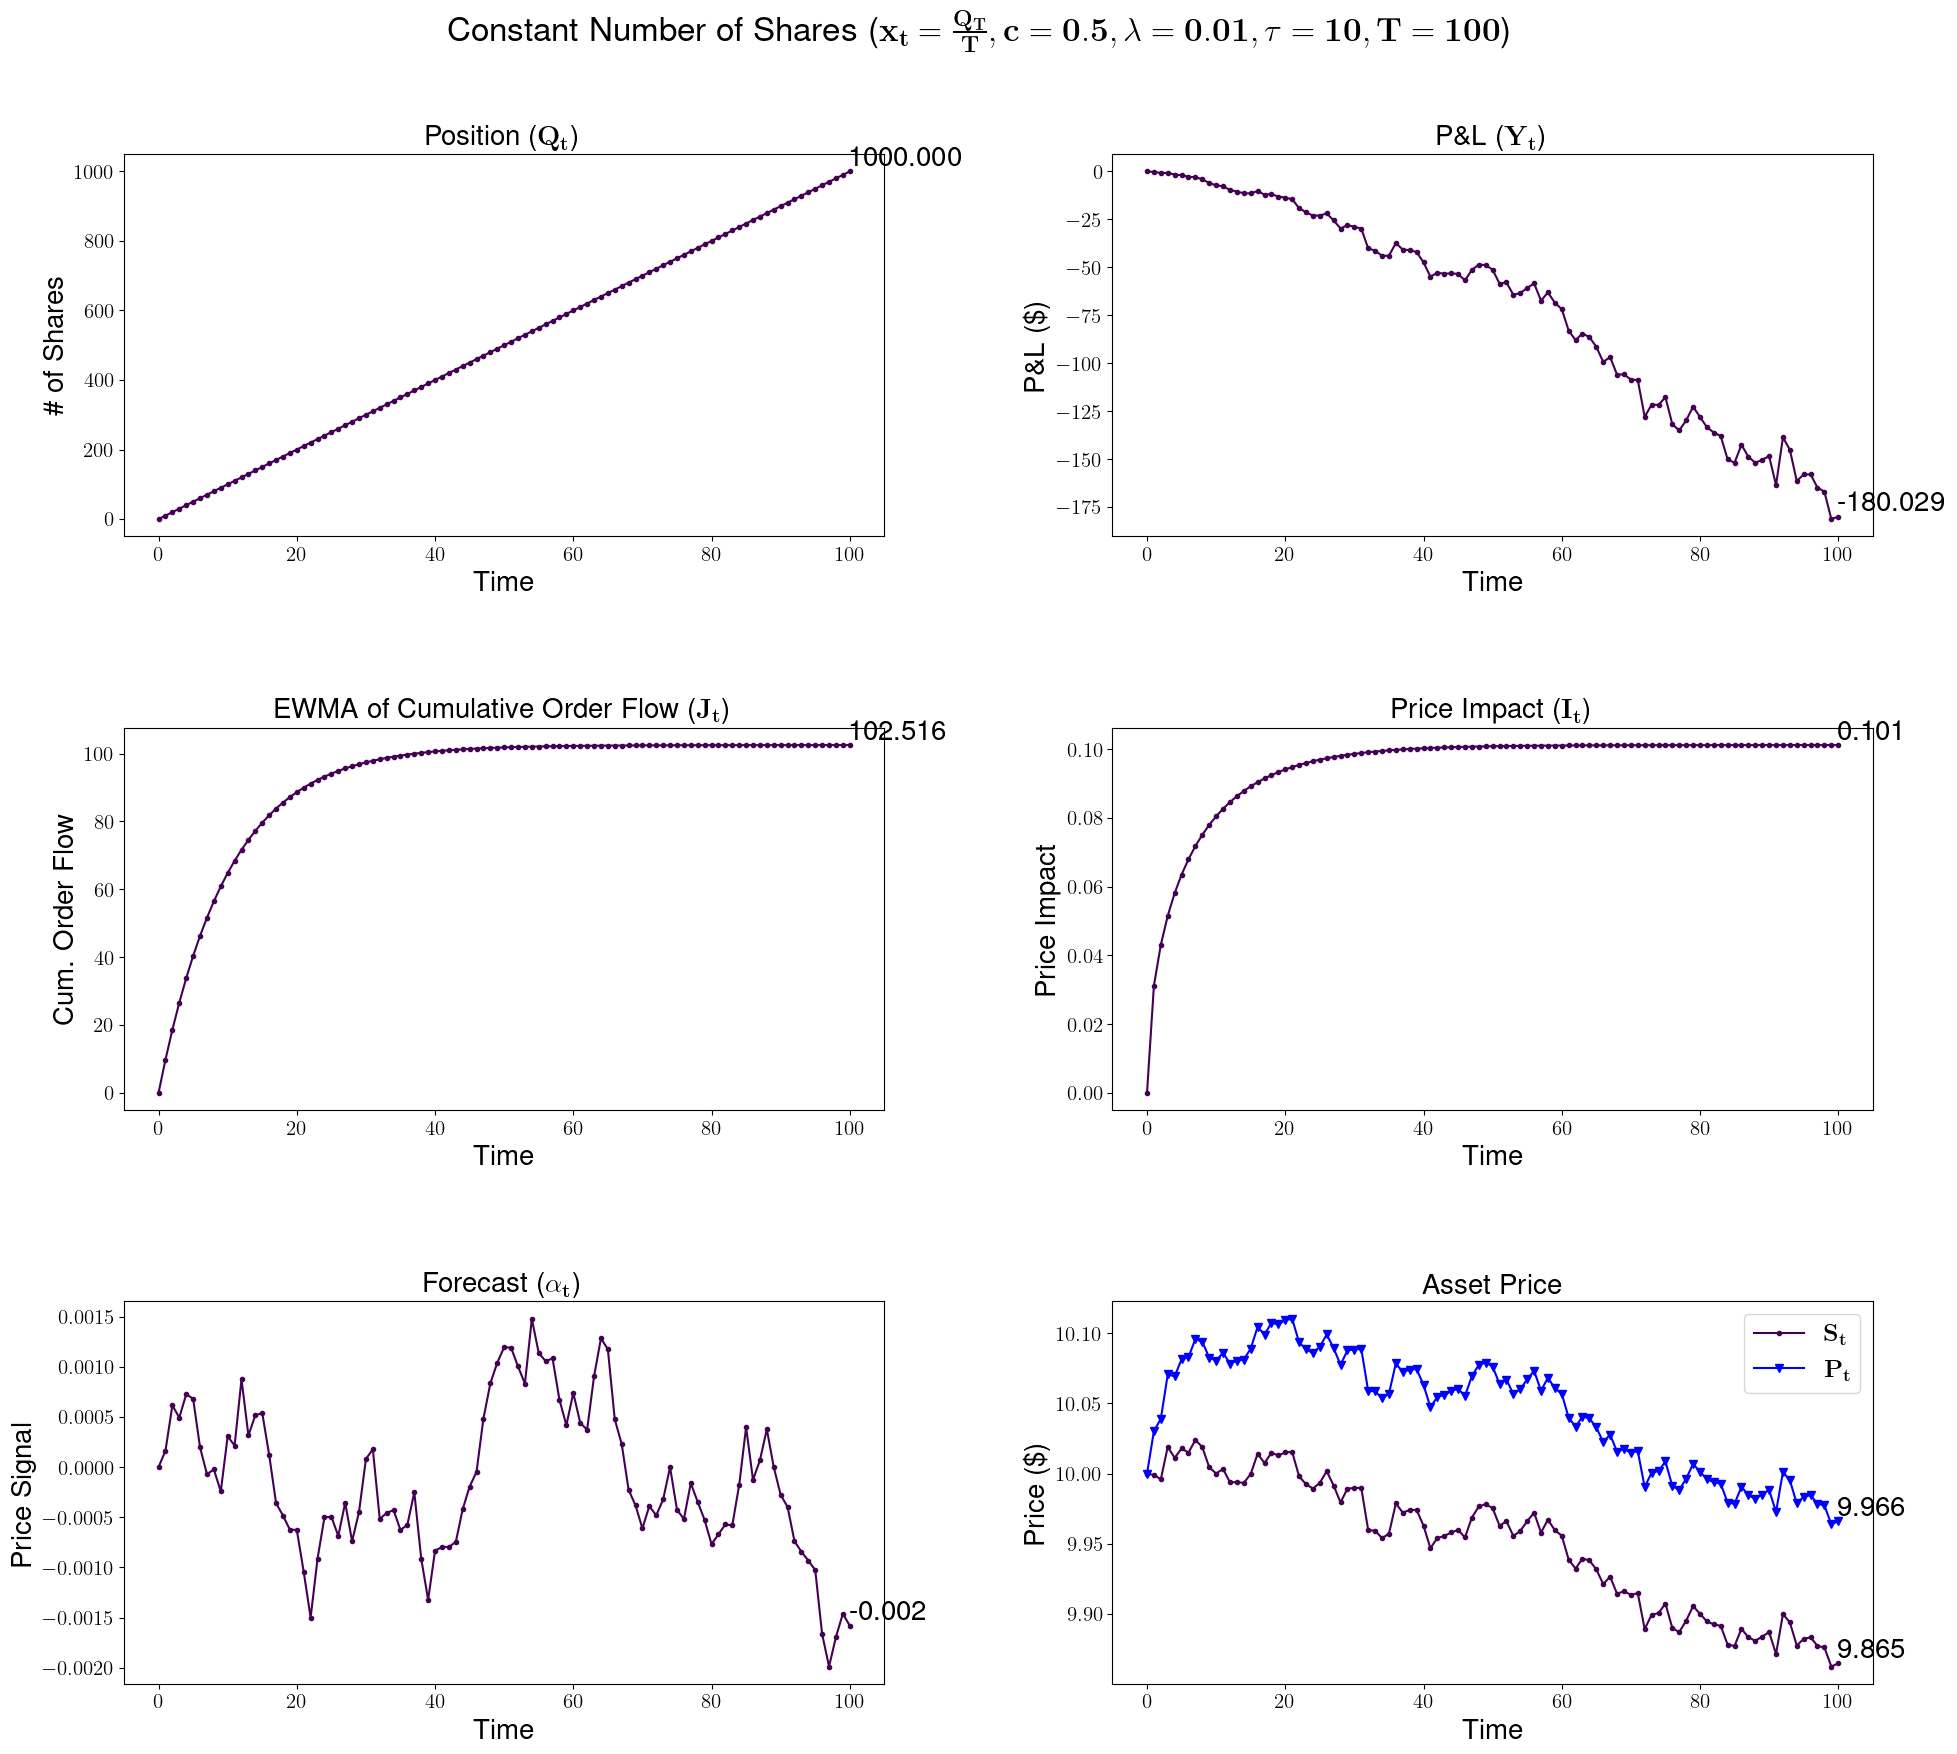

In [3]:
def const_x(tot_q, t_steps, **kwargs):
    '''
    Calculates number of shares to buy at each time step so that it's constant throughout the entire trading period.
    Takes in total quantity and number of time steps
    '''
    assert 0 < t_steps
    return tot_q/t_steps

df = sim_MC(const_x, c=0.5, n_MC = 1000)
plt.show(plot_results(r"Constant Number of Shares ($\mathbf{x_t=\frac{Q_T}{T},c=0.5,\lambda=0.01,\tau=10,T=100}$)", df, save_fig = True, fpath = "const05.png"))

# df = sim_MC(const_x, c=1, n_MC = 1000)
# plt.show(plot_results(r"Constant Number of Shares ($\mathbf{x_t=\frac{Q_T}{T},c=1,\lambda=0.5,\tau=10,T=100}$)", df, save_fig = True, fpath = "const1.png"))

## Constant Number of Shares With Alpha {-}

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_8174/1981267874.py:192: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)


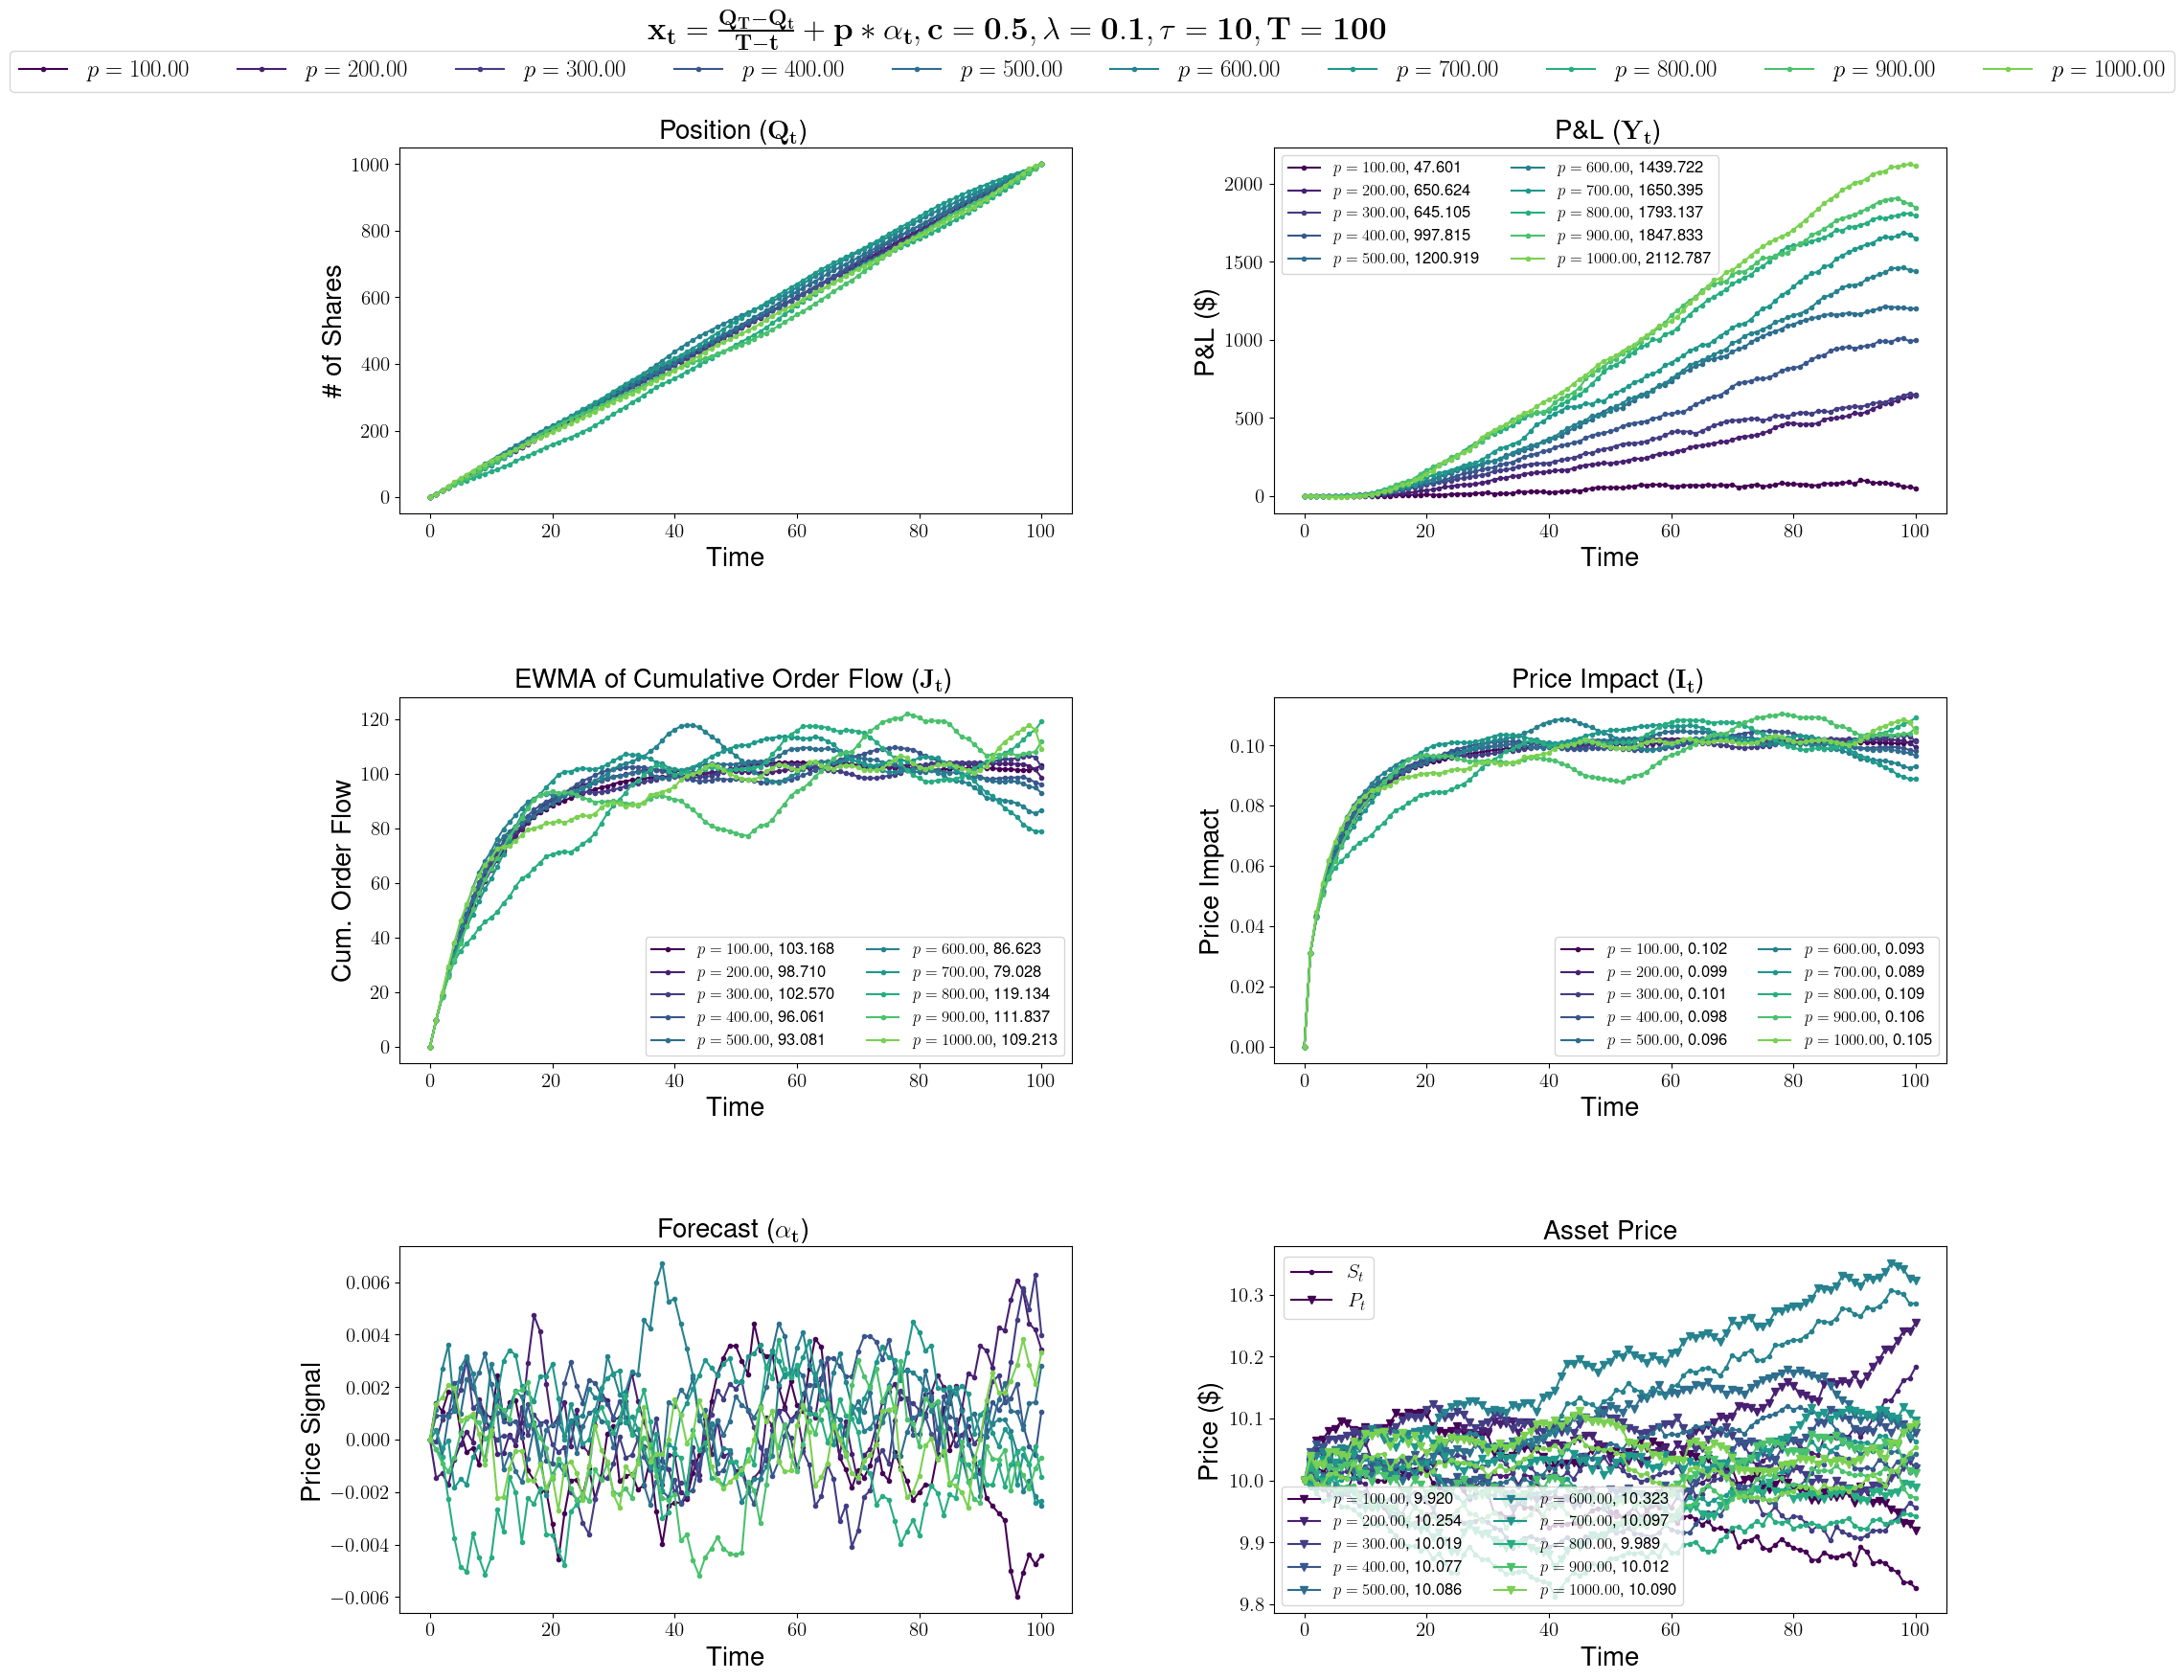

In [4]:
def const_num_alpha(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to sell for constant fraction plus alpha
    '''
    # return np.max(rem_q/rem_t + p * alpha, 0)
    return rem_q/rem_t + p * alpha


const_num_alpha_df = pd.DataFrame()

d = {}

for i in range(1, 11):
    frac = 100 * i

    d[frac] = sim_MC(const_num_alpha, key_args = {'p': frac}, c = 0.5, lamb = 0.01, gamma = 0.03)

plt.show(plot_multi_results(r"$\mathbf{x_t=\frac{Q_T-Q_t}{T-t}+p*\alpha_t,c=0.5,\lambda=0.1,\tau=10,T=100}$", d, logsc = False, save_fig=True, fpath = "constalph05"))

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_8174/1981267874.py:192: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)


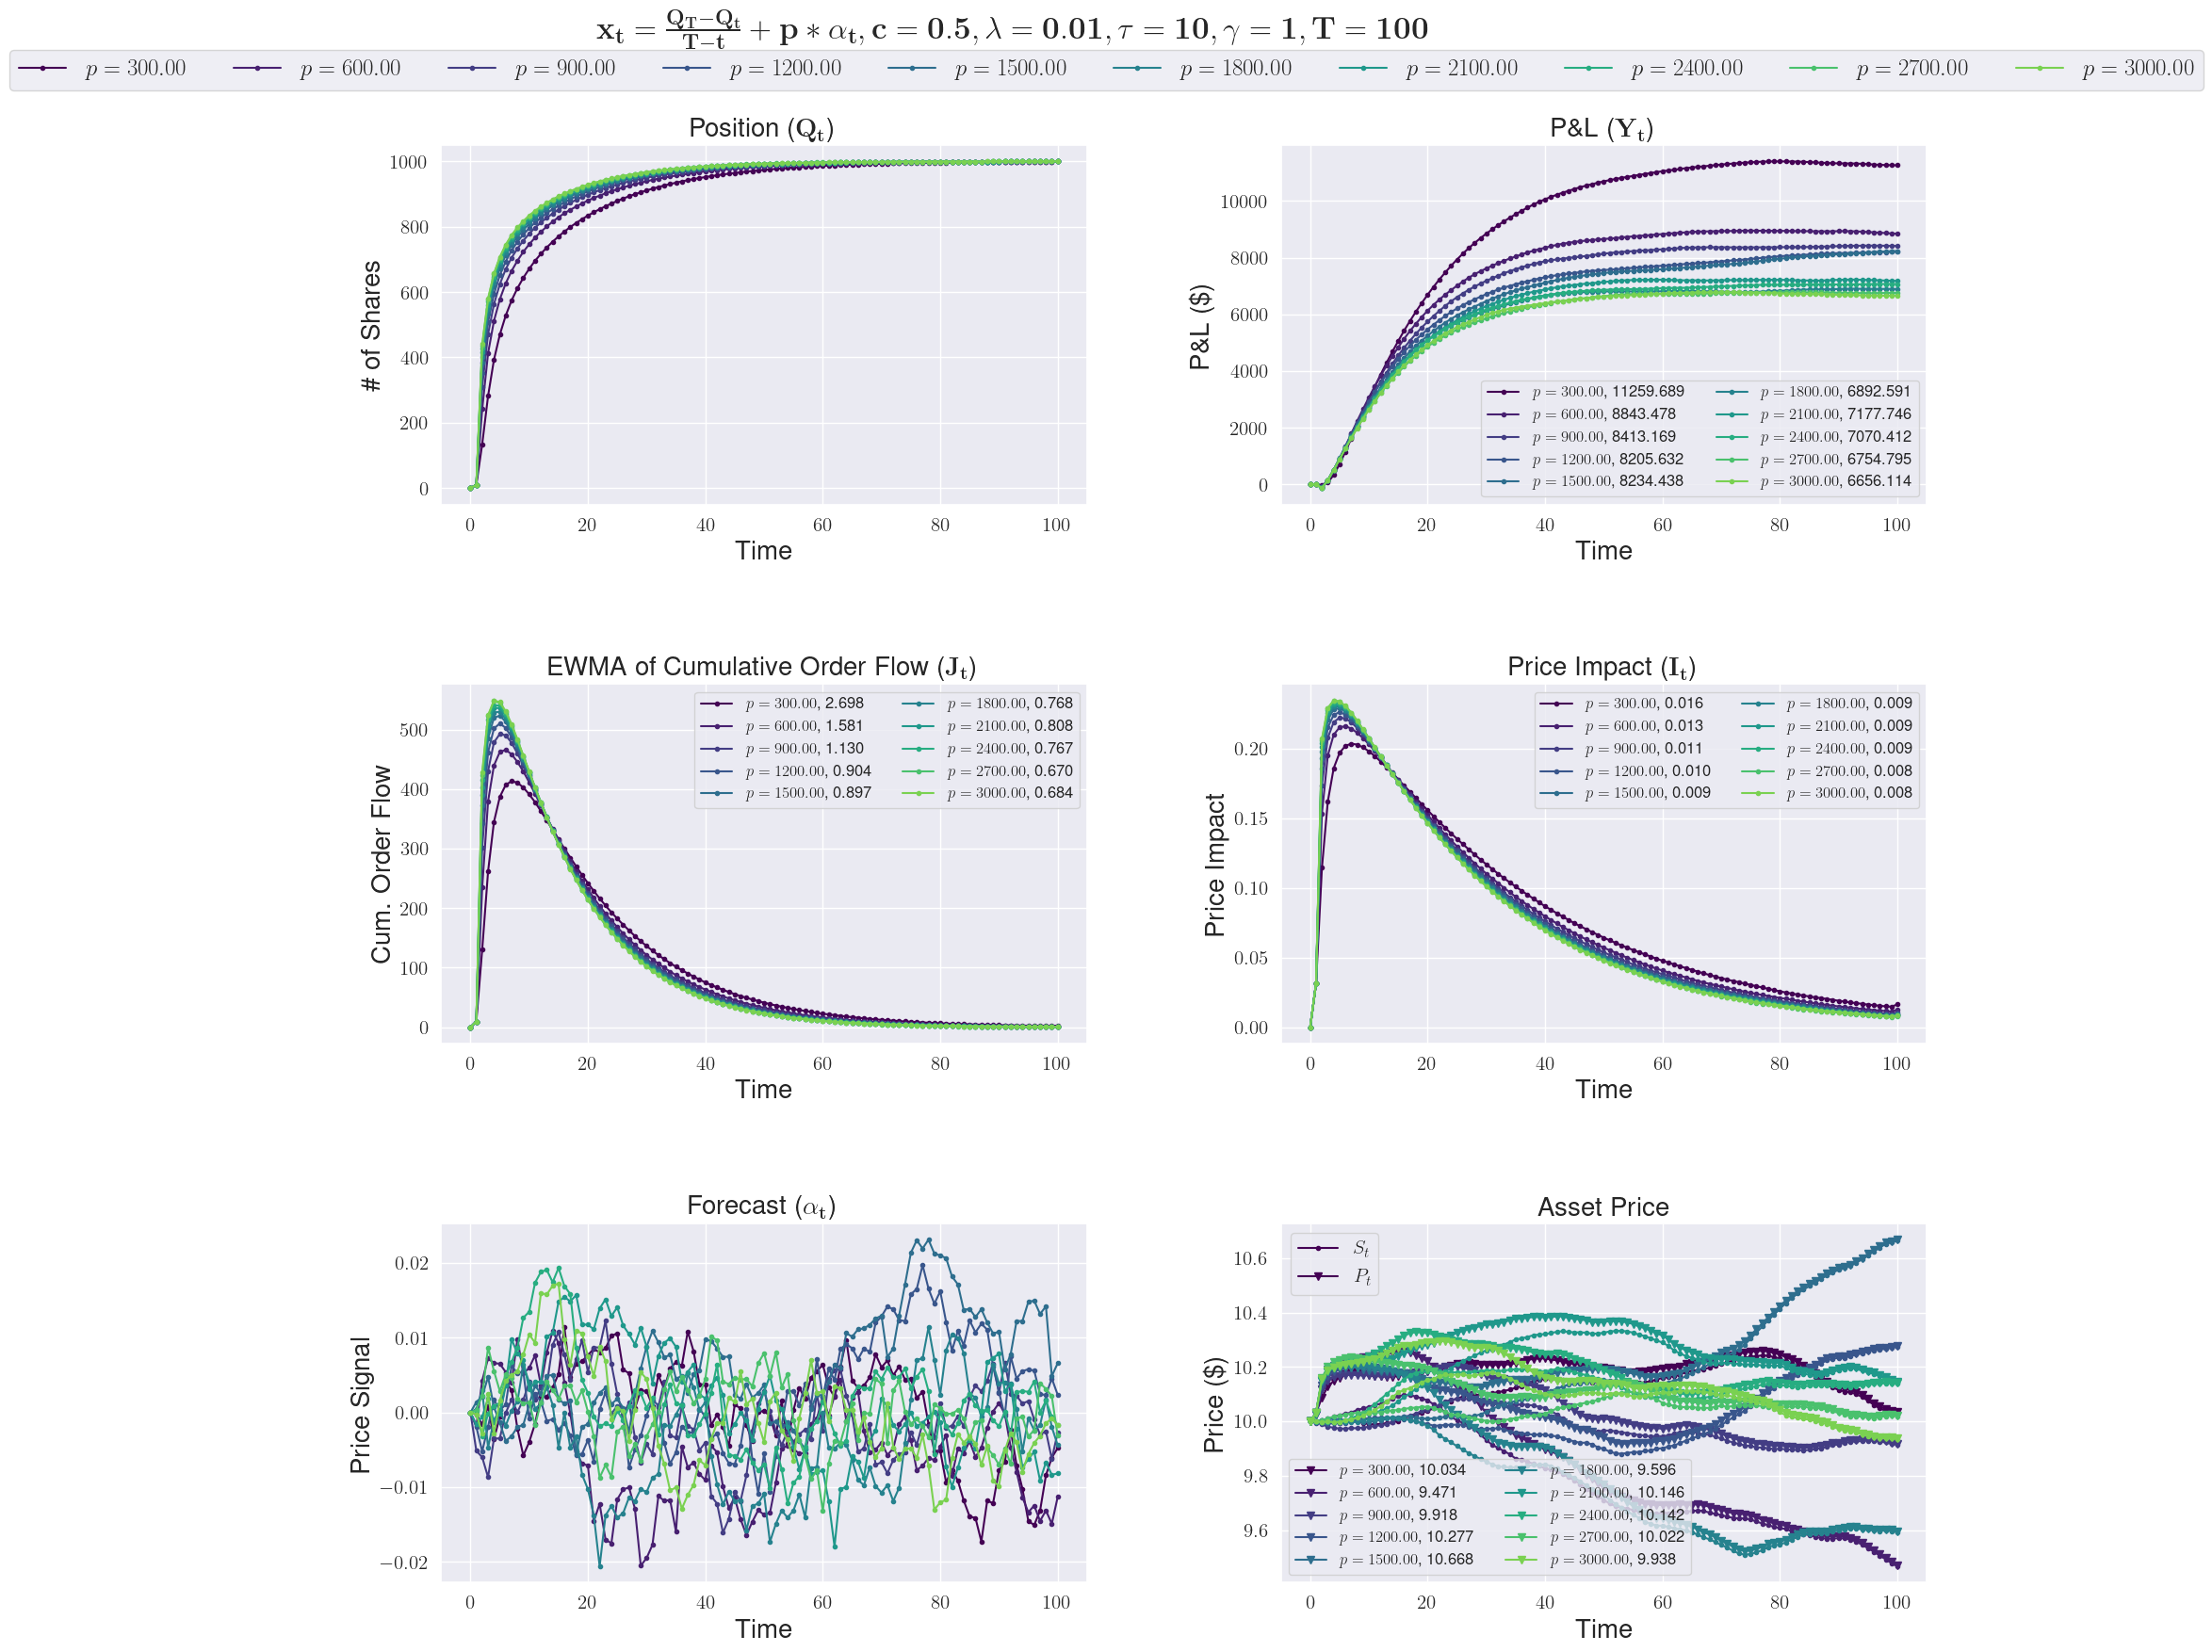

In [32]:
def const_num_alpha_no_sell(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to sell for constant fraction plus alpha
    '''
    x = np.maximum(rem_q/rem_t + p * alpha, 0)
    return np.minimum(x, rem_q)

d = {}
params = {
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'gamma': 1,
    'T': 100,
    'sigma': 0.01,
    'n_MC': 100_000,
}

for i in range(1, 11):
    frac = 300 * i

    d[frac] = sim_MC(const_num_alpha_no_sell, key_args = {'p': frac}, **params)

plt.show(plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\gamma={params['gamma']},T={params['T']}}}$", d, logsc = False, save_fig=False, fpath = "constalph05"))

Text(0, 0.5, 'P\\&L')

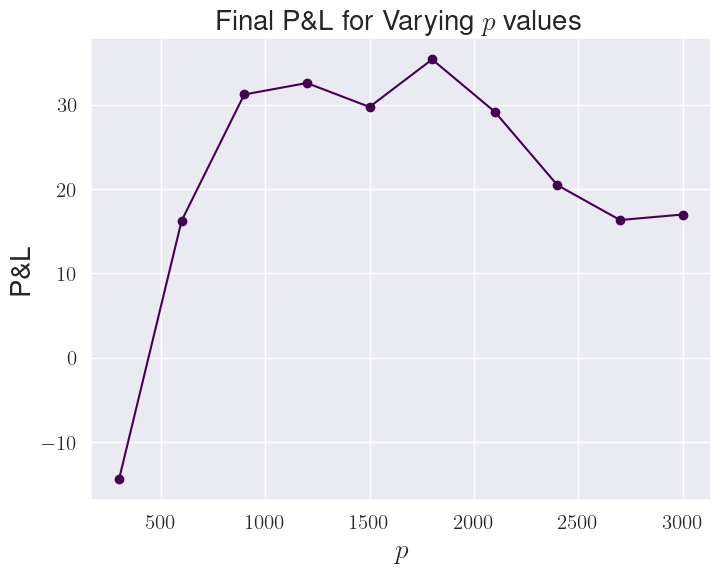

In [31]:
final_Y = np.array([d[x]['Y'].iloc[-1] for x in d.keys()])
df = pd.DataFrame({'p': d.keys(), 'Final P\&L': final_Y})
# sns.scatterplot(df, x = 'p', y = 'Final P\&L')
plt.plot(df['p'], df['Final P\&L'], 'o-')
plt.title(r"Final P\&L for Varying $p$ values")
plt.xlabel("$p$")
plt.ylabel("P\&L")

Text(0, 0.5, 'P\\&L')

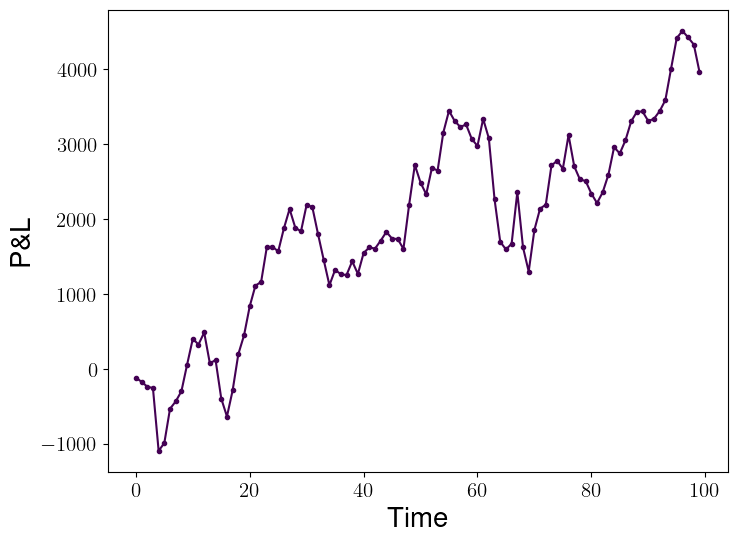